In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Monte Carlo Integration
Estimate multi-dimensional integral (over unit hypercube) by randomly sampling $N$ abscissas: 
$$ I = \int{d^dx \; f(x)} \approx  E = \frac{1}{N} \sum_{n=1}^{N}{f(x_n)} , $$
with equality for $N \rightarrow \infty $ (if the random process used to sample $x_n$ has a constant natural density). Define variance of a function $f$ as
$$ \sigma^2(f) = \int { d^dx \; (f(x)-I)^2 } .$$
Using this, the variance of the Monte Carlo estimate is
$$ 
\int { dx_1...dx_N \left( \frac{1}{N} \sum_{n=1}^N f(x_n)- I \right)^2 }
= \int { dx_1...dx_N \frac{1}{N^2} \sum_{n=1}^N \sum_{m=1}^N (f(x_n)- I)(f(x_m)- I) } 
= \int {dx_1...dx_N \frac{1}{N^2} \sum_n{(f(x_n)-I)^2}}
= \frac{\sigma(f)^2}{N},
$$
since for $n \neq m$ the integrals separate and clearly $\int{dx\;(f(x)-I)} = 0$. 

The variance can be estimated using the unbiased sample variance
$$ S^2 = \frac{1}{N-1} \sum_{n=1}^N{(f(x_n)-E)^2} = \frac{1}{N-1}\sum_n{f(x_n)^2 } - \frac{N}{N-1}E^2$$

In [2]:
class MonteCarloPlain(object):
    
    def __init__(self, dim=1, name="MC Plain"):
        self.method_name = name
        self.dim = dim
        
    def __call__(self, f, N):
        """ Compute Monte Carlo estimate of N-dimensional integral of f over the unit hypercube.
        
        Args:
            f: A function accepting self.dim numpy arrays, returning an array of the same length 
                with the function values. For function that cannot simply be factorized, 
                consider to use @numpy.vectorize before the function definition.
        Returns:
            tuple (integral_estimate, error_estimate),
            where the error_estimate is based on the unbiased sample variance of the function,
            computed on the same sample as the integral.
        """
        # using this order of N, dim to be consistent with other algorithms
        # also less awkward if N=1, compare [[1, 2]] vs [[1], [2]]
        x = np.random.rand(self.dim*N).reshape(N, self.dim)
        y = f(*x.transpose())
        mean = np.mean(y)
        var = np.var(y)
        return mean, np.sqrt(var/N)

In [3]:
# this will be useful later on to compare integration results from several MC methods
def compare_integration(f, true_value, methods,  Nmin=2, Nmax=200, Nstep=5, dim=1):
    """ Plot the exact value vs the estimates and errors of each method for various sample sizes. """
    Ns = list(range(Nmin, Nmax+1, Nstep))  # sample sizes
    samples_count = len(Ns)                # number of different sample sizes
    
    estimate = np.empty(samples_count)  # integral for each sample size
    error = np.empty(samples_count)     # error estimate for each sample size

    for method in methods:
        for i in range(samples_count):
            estimate[i], error[i] = method(f, Ns[i])
        print("{}\taverage (deviation * sqrt(N)): {}, average (error * sqrt(N)): {}".format(
                method.method_name, np.average(abs(estimate - true_value)*np.sqrt(Ns)), np.average(np.sqrt(Ns)*error)))
        
        # plot estimated integral with one-sigma error intervals
        plt.errorbar(Ns, estimate, yerr=error, fmt=".-", label=method.method_name)
    # plot true value
    plt.plot([Ns[0], Ns[-1]], [true_value, true_value], "-", label="exact value")
    # configure plot
    plt.grid()
    plt.legend(loc="best")

MC Plain	average (deviation * sqrt(N)): 0.3336028088333824, average (error * sqrt(N)): 0.47988017322561677


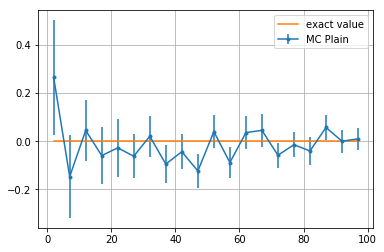

In [4]:
# simple example: sin(2 pi x)*sin(2 pi y). Integral over [0,1]^2 should give 0
def sin2d(x, y):
    # this factorizes to two sines, so we don't need to vectorize
    return np.sin(2*np.pi*x) * np.sin(2*np.pi*y)
    
compare_integration(sin2d, 0, Nmin=2, Nmax=100, methods=[MonteCarloPlain(2)])

MC Plain	average (deviation * sqrt(N)): 1.757637115846989, average (error * sqrt(N)): 1.7958313911734158


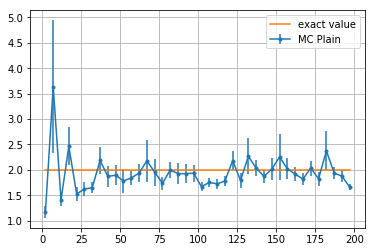

In [5]:
# f(x) = 1/sqrt(x) is integrable and MC converges to true value, but error estimate relied on square-integrability.
# the variance of f does not converge, which implies the estimate of this cannot yield a good error estimate
compare_integration(lambda x: 1/np.sqrt(x), 2, Nmax=200, Nstep=5, methods=[MonteCarloPlain()])

## Variance Reducing Techniques
The error in the MC estimate scales like $1/\sqrt{N}$, which constitutes a slow convergence. Improving this value is desirable.
### stratified sampling
Split $M=[0,1]^d$ into $k$ regions $M_j$, in each region perform MC with $N_j$ points. We obtain the estimate
$$ E = \sum_{j=1}^k {\frac{\text{vol}(M_j)}{N_j}} \sum_{n=1}^{N_j} {f(x_{jn})}, $$
and the variance of the MC estimate becomes
$$ 
\sum_{j=1}^k {\frac{\text{vol}(M_j)^2}{N_j} \left.\sigma^2(f)\right|_{M_j} }, \; \text{with} \;  
\left.\sigma^2(f)\right|_{M_j} = \frac{1}{\text{vol}(M_j)}\int_{M_j} {dx \left( f(x) - \frac{1}{\text{vol}(M_j)}\int_{M_j}{dx f(x)}  \right)^2}.
$$
Whether this method reduces or increases the variance depends on the choice of subspaces and respective point counts. It is obvious from the expression that to reduce the error/variance, regions with larger variance should have assigned larger $N_j$. Generally, for minimal variance the number of points must be chosen proportional to $\left.\sigma(f)\right|_{M_j}$.

In [6]:
# For the strafield monte carlo varient we first need a way to encode the volumes, 
# iterate over them and sample each one appropriately.
# The simplest division is simple cubic
class CubeVolumes(object):
    def __init__(self, divisions:int, Ns={}, otherNs=1, dim=1):
        """ Initialize a division of a <dim>-dimensional hypercube into <divisions> cubes along each dimension.
        
        divisions: number of subregions along one axis. For dim=3, there will be divisions^3 subregions.
        Ns: dictionary for setting the number of samples for specific subregions (cubes).
            Example: Ns={(1,0,0): 4} to assign 4 samples to the cube 1 away from the origion along the first dimension.
        otherNs: number of samples to be assigned to all remaining cubes.
        dim: dimensionality of the cube.
        """
        self.Ns = Ns
        self.divisions = divisions
        self.dim = dim
        # volume of all regions is constant
        self.vol = 1/divisions**dim
        self.otherNs = otherNs
        self.totalN = sum(Ns.values()) + (divisions**dim - len(Ns)) * otherNs
    
    def iterate(self, multiple=1):
        """ multiply N in each division by multiple. Total number of samples is self.totalN()*multiple. 
        
        yields tuple (N, sample, vol), 
        where N is the number of samples in the region, sample is a function that samples the region uniformly.
        """
        for index in np.ndindex(*([self.divisions]*self.dim)):
            def sample_region():
                return np.array(index) / self.divisions + np.random.rand(self.dim) / self.divisions
            yield multiple * (self.Ns[index] if index in self.Ns else self.otherNs), sample_region, self.vol

# iterate and sample a 1D volume, divided into 5 regions, with doulbe weight on the fourth region (index (3,))
# volumes = CubeVolumes(5, Ns={(3,): 2}, otherNs=1)
volumes = CubeVolumes(2, otherNs=2, Ns={(0,):2})
for N, sample, vol in volumes.iterate(2):
    print(N, vol, [(lambda x: 1+(x<.5)*np.sin(np.pi*x))(sample()) for i in range(N)])

4 0.5 [array([1.99421436]), array([1.99462131]), array([1.28940233]), array([1.76274148])]
4 0.5 [array([1.]), array([1.]), array([1.]), array([1.])]


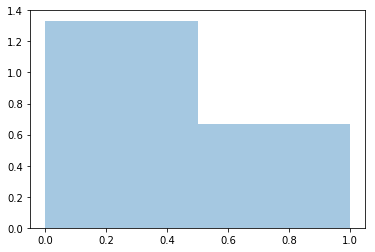

In [7]:
# visualization of 1d volumes
def plot_1d_volume(volumes, label="sampling weights"):
    assert volumes.dim == 1, "Can only plot volumes in 1 dimension."
    x = [volumes.vol*i for i in range(volumes.divisions)]
    height = [N/volumes.totalN/volumes.vol for N,_,_ in volumes.iterate()] # bar height corresponds to pdf
    rects1 = plt.bar(x, height, volumes.vol, align='edge', alpha=.4, label=label)
plot_1d_volume(CubeVolumes(2, otherNs=2, Ns={(1,): 1}))

In [8]:
class MonteCarloStratified(object):
    """ Compute Monte Carlo estimate of N-dimensional integral of f over the unit hypercube using strafield sampling.
    
    Note: N must be an integer multiple of volumes.totalN !

    Returns:
        tuple (integral_estimate, error_estimate)
    """
    def __init__(self, volumes=CubeVolumes(1), name="MC Stratified"):
        self.method_name = name
        self.dim = volumes.dim
        self.volumes = volumes
        
    def __call__(self, f, N):
        multiple = N // self.volumes.totalN 
        assert multiple > 0, "the strafield method requires the sample size N to be a multiple of volumes.totalN."
        int_est = 0  # estimated integral of f (i.e. sample average over unit cube)
        var_est = 0  # estimated variance of f
        for Nj, sample, vol in self.volumes.iterate(multiple):
            f_average = 0   # average of f over N samples in subregion
            f2_average = 0  # average of f^2 over N samples
            for i in range(Nj):
                x = sample()
                value = f(x) # f must return a 1D value
                f_average += value/Nj
                f2_average += value**2/Nj
            var_est += vol**2/Nj * (f2_average - f_average**2)
            int_est += vol * f_average
        return int_est, np.sqrt(var_est)

MC Plain	average (deviation * sqrt(N)): 0.6230093516437183, average (error * sqrt(N)): 0.706162262251182
MC Stratified	average (deviation * sqrt(N)): 0.26107642639819567, average (error * sqrt(N)): 0.35632781546422193


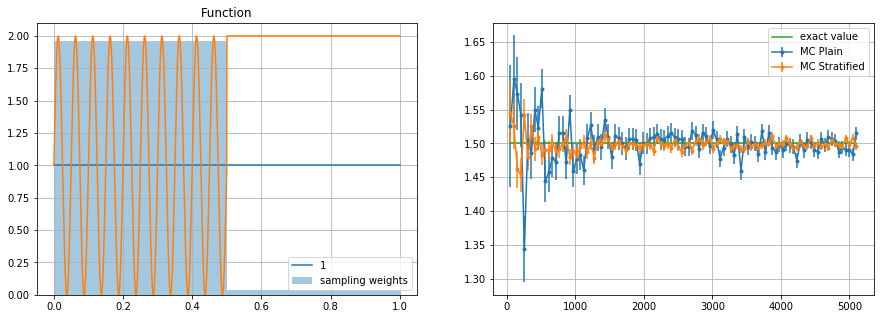

In [9]:
volumes = CubeVolumes(2, otherNs=1, Ns={(0,):50})
half_sin = lambda x: (x<.5)*(1+np.sin(4*10*np.pi*x)) + (x>.5)*2
half_sin_integral = 1.5

# plot the function
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Function")
plot_1d_volume(volumes)
x = np.linspace(0,1,1000)
plt.plot(x, [1 for i in x], label="1")
plt.plot(x,half_sin(x))
plt.grid()
plt.legend()

# compare 
plt.subplot(122)
compare_integration(half_sin, half_sin_integral, Nmin=volumes.totalN, Nmax=volumes.totalN*100, Nstep=volumes.totalN, 
                    methods=[MonteCarloPlain(), MonteCarloStratified(volumes)])

plt.show()

In [10]:
# another nice plotting routine to compare predicted and actual errors of different methods/parameter choices
# for smoothing, average over given number of iterations
def compare_errors(f, true_value, iterations=1, Nmin=2, Nmax=100, Nstep=1, methods=[]):
    Ns = list(range(Nmin, Nmax+1, Nstep))  # sample sizes
    samples_count = len(Ns)                # number of different sample sizes
    
    errors = np.zeros(samples_count)
    ms = np.zeros(samples_count)
    for m in range(len(methods)):
        for i in range(samples_count):
            errors[i] = 0
            ms[i] = 0
            for j in range(iterations):
                val, err = methods[m](f, Ns[i])
                errors[i] += err/iterations
                ms[i] += (val-true_value)**2/iterations
                
        # plot average error
        plt.title("Errors, values scaled by $\\sqrt{N}$")
        plt.xlabel("N")
        plt.plot(Ns, errors*np.sqrt(Ns), ".-", label="%s predicted"%methods[m].method_name, color="C%d"%m)
        plt.plot(Ns, np.sqrt(ms)*np.sqrt(Ns), "--", label="%s rms deviation"%methods[m].method_name, color="C%d"%m)
        # configure plot
        plt.grid()
        plt.legend(loc="best")

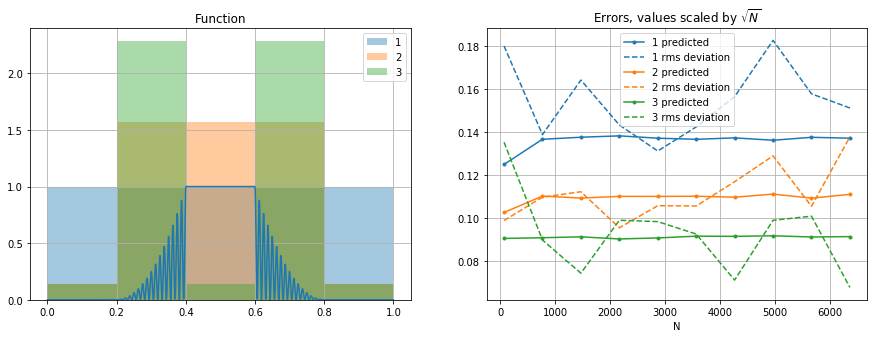

In [11]:
# on to a more compliated function to see how best to choose weights
tf_a = 16
tf_b = 1/.2**2
def osc(x):
    return x**2*np.cos(tf_a*np.pi*x/.2)**2*tf_b
def bound(a, x, b):
    return (x>a)*(x<=b)
def test_function(x):
    return bound(.2, x, .4)*osc(x-.2) + bound(.4, x, .6) + bound(.6, x, .8)*osc(.8-x)
test_function_true_value = 2*.0333531 + .2

# plot function and volume choices for stratified sampling
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Function")
x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
plt.grid()

vol1 = CubeVolumes(5, otherNs=14)
vol2 = CubeVolumes(5, otherNs=2, Ns={(1,):22, (3,):22, (2,):22})
vol3 = CubeVolumes(5, otherNs=2, Ns={(1,):32, (3,):32})
plot_1d_volume(vol1, "1")
plot_1d_volume(vol2, "2")
plot_1d_volume(vol3, "3")
plt.legend()

plt.subplot(122)

compare_errors(test_function, test_function_true_value, iterations=20, Nmin=vol1.totalN, Nmax=vol1.totalN*100, Nstep=vol1.totalN*10, 
                    methods=[MonteCarloStratified(vol1, "1"), MonteCarloStratified(vol2, "2"), MonteCarloStratified(vol3, "3")])
plt.show()

**Observation**: It is most important to increase sampling in regions where f varies quickly.

(Note: stratified sampling is substantially different from importance sampling, which is why for stratified sampling regions of large variance of f should have bigger weights, whereas for importance sampling the pdf should be as close to f as possible.
In stratified sampling each region is considered individually and therefore when f is large but constant small samples will be acceptable. If $p(x)$ in importance sampling is small in these regions, these large values of f would be underrepresented and (as they yield large values of $f(x)/p(x)$) increase the variance of the MC estimate.)

### importance sampling
Consider a change of variables
$$ \int {dx \; f(x)} = \int {\frac{f(x)}{p(x)} dx} = \int {\frac{f(x)}{p(x)} dP(x)} $$
with $$ p(x) = \frac{\partial^d}{\partial x_1 ... \partial x_d} P(x) .$$

Interpret $p(x)$ as a probability density with $p(x) \geq 0$ and normalized: $\int{dx\;p(x)} = 1$. If the $x_n$ are sampled from the corresponding distribution $P(x)$, we have
$$ E = \frac{1}{N} \sum_{n=1}^{N}{\frac{f(x_n)}{p(x_n)}}.$$
The variance of the MC estimate is (analogously to the first calculation)
$$ 
\int { dx_1...dx_N \; p(x_1)...p(x_N)\left( \frac{1}{N} \sum_{n=1}^N f(x_n)- I \right)^2 } 
= \frac{1}{N} \int {dx \; p(x) \left( \frac{f(x)}{p(x)} - I \right)^2 } = \frac{\sigma^2(f/p)}{N} \;,
$$
which may in turn be estimated by the sample variance, using E instead of I:
$$ 
\sigma^2\left(\frac{f}{p}\right) \approx S^2\left(\frac{f}{p}\right) 
= \frac{1}{N} \sum_{n=1}^N {\left(\frac{f(x_n)}{p(x_n)}\right)^2} - E^2 .
$$

Using $p$ which are (close to) zero where $f$ is not zero is dangerous as the variance diverges while the sample variance does not (appropriate regions are less likely to be sampled for small $p$).

In [12]:
class MonteCarloImportance(object):
    """ 
    By default, uniform probability distribution is used. pdf is weight function given the sampling distribution.

    Args:
        sampling_fn: Function taking one argument N, random number according to the desired distribution, 
            i.e. an array of shape (N, dim).
            If dim = 1, may also return a simple numpy array of length N.
        pdf: Function with the same signature as the integrand. Takes dim numpy arrays of size N and returns
            one numpy array of size N giving the probability density of the sampling funciton for each point.
    
    """
    def __init__(self, dim=1, sampling_fn=None, pdf=lambda *x:1, name="MC Importance"):
        self.method_name = name
        
        self.dim = dim
        if sampling_fn is None:
            sampling_fn = lambda N: np.random.rand(N * self.dim).reshape(N, self.dim)
        self.sampling_fn = sampling_fn
        self.pdf = pdf
    
    def __call__(self, f, N):
        x = self.sampling_fn(N)
        # allow x to be a simple array if dim=1
        if x.ndim == 1:
            x = x[:, np.newaxis]
            
        y = f(*x.transpose()) / self.pdf(*x.transpose())
        
        mean = np.mean(y)  # integral estimate
        var = np.var(y)    # variance of the weighted function samples
        return mean, np.sqrt(var/N)

MC Plain	average (deviation * sqrt(N)): 0.2535036689578044, average (error * sqrt(N)): 0.35246855244157016
MC Importance	average (deviation * sqrt(N)): 0.2902723919319738, average (error * sqrt(N)): 0.3538000749934978


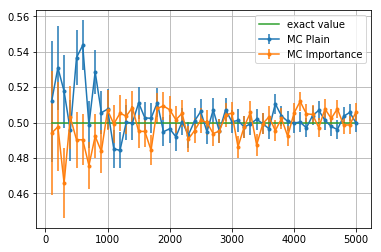

In [13]:
# with the default values (uniform distribution) monte carlo importance and plain monte carlo are exactly equivalent 
f = lambda x: np.sin(x*2*np.pi)**2
compare_integration(f, 1/2, Nmin=100, Nmax=5000, Nstep=100, 
                    methods=[MonteCarloPlain(), MonteCarloImportance()])

## Generating Samples from a Given Distribution
### Acceptance-Rejection method
We want to sample according to a pdf $p(x)$. We know another (similar) pdf $h(x)$ s.t. $p(x) \leq Ch(x)$ for some $C \geq 0$.
Then use the following algorithm:
1. sample $x$ according to $h$
2. generate random number $u \in [0,1]$ and accept $x$ if $p(x) \geq uCh(x)$, else reject and start over

In [90]:
def assure_2d(array):
    if array.ndim == 2:
        return array
    elif array.ndim == 1:
        return array[:, np.newaxis]
    else:
        raise RuntimeError("Array must be 1 or 2 dimensional.")
            
class AcceptionRejection(object):
    # for use in monte carlo it will be useful to have a parameter-less sample function, 
    # therefore use a callable object
    def __init__(self, p, C, dim=1, sample_pdf=lambda *x: 1, sample_generator=None):
        """
        Args:
            p: Unnormalized (!) probability distribution function.
            sample_pdf: Probability distribution of known sample_generator.
        """
        self.p = p
        self.C = C
        self.dim = dim
        self.sample_pdf = sample_pdf
        if sample_generator is None:
            sample_generator = lambda N: np.random.rand(N * self.dim).reshape(N, self.dim)
        self.sample = sample_generator
        
    def __call__(self, N):
        x = np.empty((N, self.dim))
            
        indices = np.arange(N)
        while indices.size > 0:
            proposal = assure_2d(self.sample(indices.size))
            accept = np.random.rand(indices.size) * self.C * self.sample_pdf(*proposal.transpose()) <= self.p(*proposal.transpose())
            x[indices[accept]] = proposal[accept]
            indices = indices[np.logical_not(accept)]
        return x

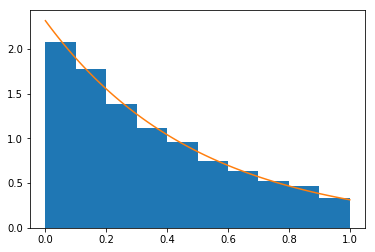

In [91]:
# 1D example
a = 2
p = lambda x: a/(1-np.exp(-a)) * np.exp(-a*x)  # want to sample according to this
acception_rejection = AcceptionRejection(p, 5)

plt.hist(acception_rejection(10000), bins=10, normed=True)
plt.plot(np.linspace(0,1,100), p(np.linspace(0,1,100)))

### Metropolis algorithm
The metropolis algorithm is a simple Markov chain that, in it's limit, generates the desired distribution.
It starts from a state $\phi$ and transitions to a new state $\phi'$.

In [707]:
class Metropolis(object):
    def __init__(self, initial, pdf, dim=1, proposal_generator=None):
        """
        Note, here the proposal must not depend on the current state. Otherwise use 
        the Metropolis Hasting algorithm.
        """
        if proposal_generator is None:
            proposal_generator = lambda s: np.random.rand(dim)
        
        self.state = initial
        self.pdf = pdf
        self.dim = dim
        self.proposal_generator = proposal_generator
        
    def __call__(self, N=1, get_accept_rate=False):
        chain = np.empty((N, self.dim))
        
        if get_accept_rate:
            accepted = 0
            
        for i in range(N):
            proposal = self.proposal_generator(self.state)
            # hasting ratio
            r = self.pdf(proposal)/self.pdf(self.state)
            a = min(1, r)
            if a == 1 or np.random.rand() < a:
                self.state = chain[i] = proposal
                
                if get_accept_rate:
                    accepted += 1
            else:
                chain[i] = self.state
                
        if get_accept_rate:
            return chain, accepted / N
        return chain
    
class MetropolisHasting(object):
    def __init__(self, initial, pdf, dim=1, proposal_pdf=None, proposal_generator=None):
        """
        Note, here the proposal must not depend on the current state. Otherwise use 
        the Metropolis Hasting algorithm.
        
        Args:
            proposal_pdf: takes two dim-dimensional numpy arrays (state, candidate)
        """
        if proposal_pdf is None or proposal_generator is None:
            proposal_pdf = lambda state, candidate: 1
            proposal_generator = lambda s: np.random.rand(dim)
        
        self.state = initial
        self.pdf = pdf
        self.dim = dim
        self.proposal_pdf = proposal_pdf
        self.proposal_generator = proposal_generator
        
    def __call__(self, N=1, get_accept_rate=False):
        chain = np.empty((N, self.dim))
        
        if get_accept_rate:
            accepted = 0
        
        for i in range(N):
            proposal = self.proposal_generator(self.state)
            # hasting ratio
            r = self.pdf(proposal)*self.proposal_pdf(proposal, self.state)/self.pdf(self.state)/self.proposal_pdf(self.state, proposal)
            a = min(1, r)
            if a == 1 or np.random.rand() < a:
                self.state = chain[i] = proposal
                
                if get_accept_rate:
                    accepted += 1
            else:
                chain[i] = self.state
        
        if get_accept_rate:
            return chain, accepted / N
        return chain

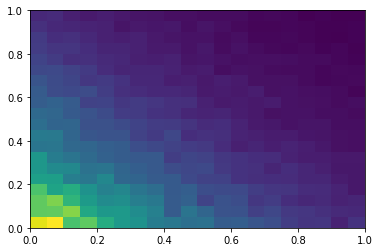

In [698]:
# test Metropolis
a = 2
p = lambda x: a**2/(1-np.exp(-a))**2 * np.exp(-a*x[0]-a*x[1])
metropolis = Metropolis(np.array([.5, .5]), p, dim=2)
rand = metropolis(100000).transpose()
_= plt.hist2d(rand[0], rand[1], bins=20, normed=True)

MC Plain	average (deviation * sqrt(N)): 0.2530410909317847, average (error * sqrt(N)): 0.35503195720894354
MC Importance	average (deviation * sqrt(N)): 0.03253073224729848, average (error * sqrt(N)): 0.02960926029929701


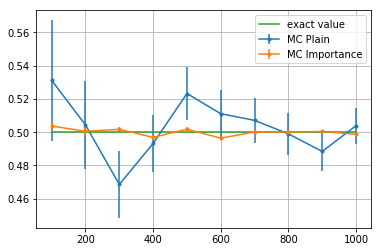

In [18]:
# Now apply distributions to importance sampling

# sin^2
f = lambda x: np.sin(x*2*np.pi)**2

p_ideal = lambda x: f(x+.005) / (1/2) # almost ideal
sampling = AcceptionRejection(p_ideal, 2) # max value of f is 1

compare_integration(f, 1/2, Nmin=100, Nmax=1000, Nstep=100, 
                    methods=[MonteCarloPlain(), MonteCarloImportance(sampling_fn=sampling, pdf=p_ideal)])

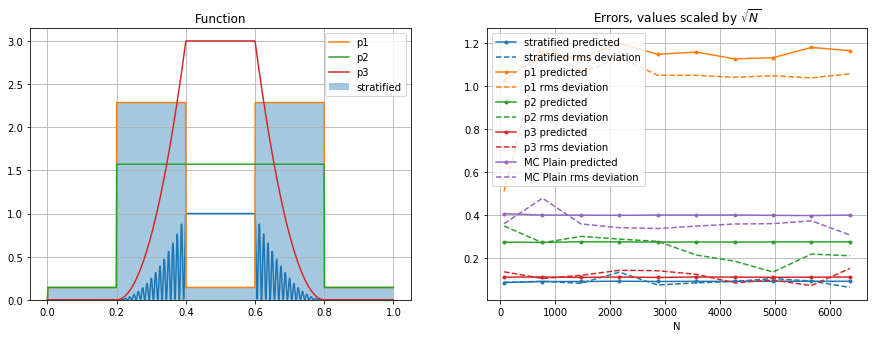

In [19]:
# use test_function and true_value from earlier

# compare importance sampling to the stratified boxing from before
vol = CubeVolumes(5, otherNs=2, Ns={(1,):32, (3,):32})
p1 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*32 + bound(.4,x,.6)*2 + bound(.6,x,.8)*32 + bound(.8,x,1)*2)/vol.totalN/.2
p2 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*22 + bound(.4,x,.6)*22 + bound(.6,x,.8)*22 + bound(.8,x,1)*2)/vol.totalN/.2
p3 = lambda x: (bound(.2,x,.4)*((x-.2)/.2)**2 + bound(.6,x,.8)*((.8-x)/.2)**2 + bound(.4,x,.6))/(.2 + .1333333)
sampling1 = AcceptionRejection(p1, 3)
sampling2 = AcceptionRejection(p2, 2)
sampling3 = AcceptionRejection(p3, 3.5)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Function")
x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
plt.grid()

plt.plot(x,p1(x), label="p1")
plt.plot(x,p2(x), label="p2")
plt.plot(x,p3(x), label="p3")
plot_1d_volume(vol, "stratified")
plt.legend()

plt.subplot(122)
compare_errors(test_function, test_function_true_value, iterations=10, Nmin=vol1.totalN, Nmax=vol1.totalN*100, Nstep=vol1.totalN*10, 
               methods=[MonteCarloStratified(volumes=vol, name="stratified"),
                        MonteCarloImportance(sampling_fn=sampling1, pdf=p1, name="p1"),
                        MonteCarloImportance(sampling_fn=sampling2, pdf=p2, name="p2"),
                        MonteCarloImportance(sampling_fn=sampling3, pdf=p3, name="p3"),
                        MonteCarloPlain()])
plt.show()

## Adaptive Methods
### VEGAS Monte Carlo

In [20]:
def damped_update(old, new, c, j):
    return new * (c)/(j+1+c) + (j+1)/(j+1+c) * old

In [21]:
# VEGAS
class MonteCarloVEGAS(object):
    def __init__(self, Nj=100, dim=1, divisions=1, c=3, name="MC VEGAS"):
        """
        c: each iteration, the bin sizes are a combination of old and new bin sizes.
            the weight of the old bin sizes increases with the number of iterations.
            c gives the iteration where both have equal weight (=1 -> equal in first iteration).
            therefore: larger c means the bins change more, smaller means the bins tend to stay close to uniform.
        """
        self.dim = dim
        self.sizes = np.ones((dim, divisions))/divisions  # the configuration is defined by the sizes of the bins
        self.Nj = Nj  # number of samples per iteration
        self.divisions = divisions  # number of bins along each axis
        self.c = c  # measure of damping (smaller means more damping)
        self.method_name = name
        
    def choice(self):
        """ Return a random choice ob bin, specified by its multi-index. """
        return np.random.randint(0, self.divisions, self.dim)
        
    def random_x(self, bin_index):
        """ Return a random number in the bin of given multi-index. """
        x = np.empty(self.dim)
        for i in range(self.dim):
            x[i] = np.sum(self.sizes[i][:bin_index[i]])
        x += self.sizes[np.arange(self.dim), bin_index] * np.random.rand(self.dim)
        return x
    
    def pdf(self, bin_index):
        """ Give the probability density of finding a point in bin with given index. """
        return 1/np.power(self.divisions, self.dim) / np.prod(self.sizes[np.arange(self.dim), bin_index])
        
    def plot_pdf(self):
        """ Plot the pdf resulting from the current bin sizes. """
        assert self.dim == 1, "Can only plot 1D pdf"
        xs = []
        ys = []
        x = 0
        for i, size in zip(range(self.divisions), self.sizes[0]):
            xs.append(x)
            y = 1/self.divisions/size
            ys.append(y)
            x += size
            xs.append(x)
            ys.append(y)
        plt.plot(xs, ys, label="VEGAS pdf")
        
    def __call__(self, f, N, apriori=True, xhi=False):
        if apriori:
            # start anew
            self.sizes = np.ones((self.dim, self.divisions))/self.divisions
            
        assert N >= self.Nj, "N must be at least Nj (default 100) initially set."
        
        Nj = self.Nj
        m = N // Nj       # number of iterations (the true N is smaller or equal the passed N parameter!)
        Ej = np.zeros(m)  # The estimate in each iteration j
        Sj = np.zeros(m)  # sample variance in each iteration j, estimating the variance of Ej

        for j in range(m):
            Ei = np.zeros((self.dim, self.divisions))
            Ni = np.zeros((self.dim, self.divisions))  # keep track of number of samples in each "projected" bin
            for i in range(Nj):
                bin_index = self.choice()
                x = self.random_x(bin_index)
                f_sample = f(x) / self.pdf(bin_index)
                Ej[j] +=  f_sample / Nj
                Sj[j] += (f_sample)**2 / Nj
                # in each dimension add the contribution to the given bin index (so in total add in self.dim places)
                Ei[np.arange(self.dim), bin_index] += f_sample / Nj
                
            # new size = 1/(old value * (getting larger with j) + best guess new * (getting smaller with j))
            self.sizes = 1/damped_update(Ej[j]/self.sizes, self.divisions * Ei, self.c, j)
            self.sizes = self.sizes / np.add.reduce(self.sizes, axis=1)[:, np.newaxis] # normalize
            
        Sj -= Ej**2             # at this point Sj is the sample variance of f/pdf
        Sj = Sj / Nj            # this completes the computation of Sj (estimated variance of Ej)
        
        C = np.sum(Nj/Sj)       # normalization factor
        E = np.sum(Nj*Ej/Sj)/C  # final estimate of e: weight by Nj and Sj (note: could generalize to make Nj vary with j)
        if xhi:
            # xhi^2/dof, have m values that are combined so here dof = m - 1
            xhi2 = np.sum((Ej - E)**2/Sj)/(m-1)
            return E, np.sqrt(np.sum(Nj**2/Sj)/C**2), xhi2
        else:
            return E, np.sqrt(np.sum(Nj**2/Sj)/C**2)

In [22]:
# see if the equation for error estimate is reasonable
trueval = .25
f = lambda x: x[0]*x[1]
ms = 0
var_mean = 0
N = 1000
for i in range(N):
    vegas = MonteCarloVEGAS(dim=2, divisions=10)
    E, var = vegas(f, 100)
    ms += (E - trueval)**2 / N
    var_mean += var/N
print(np.sqrt(ms), var_mean)

0.02256576647132731 0.02183028502555


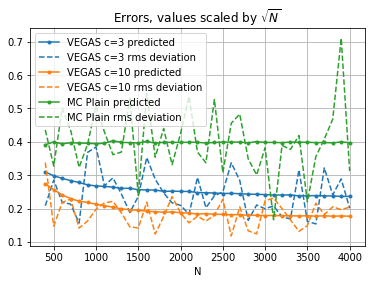

In [23]:
vegas3 = MonteCarloVEGAS(divisions=10, Nj=100, c=3, name="VEGAS c=3")
vegas5 = MonteCarloVEGAS(divisions=10, Nj=100, c=10, name="VEGAS c=10")
compare_errors(test_function, test_function_true_value, iterations=10, Nmin=400, Nmax=4000, Nstep=100,
               methods=[vegas3, vegas5, MonteCarloPlain()])

(0.2671578599925162, 0.0006139336304908526, 0.9372830246431642)


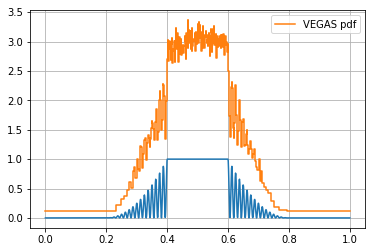

In [24]:
vegas = MonteCarloVEGAS(divisions=300, Nj=1000, c=400)
print(vegas(test_function, 50000, xhi=True))

x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
vegas.plot_pdf()
plt.legend()
plt.grid()

## Multi Channel Monte Carlo

In [613]:
class Channels(object):
    def __init__(self, sampling_channels, channel_pdfs, cweights=None):
        assert len(sampling_channels) == len(channel_pdfs), "Need a pdf for each sampling function."
        
        self.count = len(sampling_channels)
        self.cweights = np.ones(self.count)/self.count if cweights is None else cweights
        self.init_cweights = self.cweights
        self.sampling_channels = sampling_channels
        self.channel_pdfs = channel_pdfs
        
        self.Ni = np.zeros(self.count)  # hold sample_count
        
    def reset(self):
        self.cweights = self.init_cweights
        
    def pdf(self, *x):
        p = 0
        for i in range(self.count):
            p += self.cweights[i] * self.channel_pdfs[i](*x)
        return p
    
    def plot_pdf(self):
        x = np.linspace(0, 1, 1000)
        y = [self.pdf(xi) for xi in x]
        plt.plot(x, y, label="total pdf")
        
    def sample(self, N, return_sizes=False):
        choice = np.random.rand(N)
        sample_sizes = np.empty(self.count, dtype=np.int)     
        a_cum = 0
        for i in range(self.count):
            sample_sizes[i] = np.count_nonzero(np.logical_and(a_cum < choice, choice <= a_cum + self.cweights[i]))
            a_cum += self.cweights[i]
        
        sample_channel_indices = np.where(sample_sizes > 0)[0]
        
        samples = np.concatenate([assure_2d(self.sampling_channels[i](sample_sizes[i])) 
                                  for i in sample_channel_indices])
        
        if return_sizes:
            return samples, sample_sizes
        else:
            return samples
    
    def generate_sample(self, N):            
        samples, sample_sizes = self.sample(N, True)
        
        self.full_sample_sizes = sample_sizes
        # ignore channels with sample_count == 0
        self.sample_channel_indices = np.where(sample_sizes > 0)[0]
        self.sample_cweights = self.cweights[self.sample_channel_indices]
        self.sample_sizes = self.full_sample_sizes[self.sample_channel_indices]
        self.sample_count = self.sample_sizes.size  # number of channels active in current sample
        self.sample_bounds = np.array([np.sum(self.sample_sizes[0:i]) for i in range(self.sample_count)])
        
        self.samples = samples
        self.sample_weights = self.pdf(*samples.transpose())
        
    def update_sample_cweights(self, new_cweights):
        """ Update channels at self.sample_channel_indices with given values. """
        self.cweights[self.sample_channel_indices] = new_cweights

In [902]:
# test channel sampling
channels = Channels([lambda N: np.random.rand(N*3).reshape(N,3), lambda N: np.random.rand(N*3).reshape(N,3)/2], [lambda *x: 1, lambda x, y, z: 2*(z<=.5)*(x<=.5)*(y<=.5)])
channels.generate_sample(1000)
np.add.reduceat(channels.samples, channels.sample_bounds)  / channels.sample_sizes[:, np.newaxis]

array([[0.5057678 , 0.47794351, 0.50557402],
       [0.2472902 , 0.24601542, 0.25983626]])

In [616]:
class MonteCarloMultiImportance(object):
    def __init__(self, channels, Nj=100, m1=0, m2=1, m3=0, b=.5, name="MC Imp. Mult.", var_weighted=False):
        """ 
        
        The total number of integrand evaluations is N = (m1 + m2 + m3) * Nj 
        
        The integration is split into three phases, each of which containing several iterations.
        
        Phase 1: Update weights but discrad integral estimates.
        Phase 2: Update weights and use the results for the integral estimation.
        Phase 3: Don't update weights and continue using the current weights to estimate the integral.
        
        Args:
            b: exponent between 1/2 and 1/4, used in updating the weights.
            var_weighted: Enabling weighting the estimate with the individual variances.
        """
        self.method_name = name
        self.channels = channels
        self.var_weighted = var_weighted
        self.b = b
        
    def get_interface_const_iterations(self, Nj=100, m1=0, m2=1, m3=0):
        """ Get a function that estimates the integral given the function and a total number of evaluations.
        
        Args:
            Nj: Number of function evaluations in each iteration in each phase
            m1: Iterations in phase 1.
            m2: Iterations in phase 2.
            m3: Iterations in phase 3.
        """
        def interface(f, N, apriori=True):
            return self(f, [Nj]*m1, [Nj]*m2, [Nj]*m3, apriori=apriori)
        interface.method_name = self.method_name
        
        return interface
      
    def get_interface_ratios(self, Nj=100, r1=0, r2=1, r3=0, b=.5):
        """ Get a function that estimates the integral given the function and a total number of evaluations.
        
        If a given N cannot be split equally into bins of size Nj,
        spend the remaining iterations in phase 3.
        
        Args:
            r1: gives the ratio of iterations spent in the first phase
            r2: ratio of second phase (by default 1-r1-r3)
            r3: ratio of third phase (by default 0)
        """
        if r1 < 0 or r2 < 0 or r3 < 0:
            raise ValueError("Ratios cannot be smaller than 0: %d, %d, %d."%(r1, r2, r3))
        if not np.isclose(1, r1+r2+r3):
            raise ValueError("Ratios must sum to 1: %d + %d + %d = %d."%(r1, r2, r3, r1+r2+r3))
            
        def interface(f, N, apriori=True):
            num_iterations = N // Nj
            m1 = int(r1 * num_iterations)
            m2 = int(r2 * num_iterations)
            m3 = int(r3 * num_iterations)
            N_remaining = N - (m1 + m2 + m3) * Nj
            
            N3 = [Nj]*m3
            if N_remaining:
                N3.append(N_remaining)                
            return self(f, [Nj]*m1, [Nj]*m2, N3, apriori=apriori)
        interface.method_name = self.method_name
        
        return interface
        
    def iterate(self, f, N, update_weights=True, compute_estimate=True):
        """ 
        One iteration of the algorithm with sample size N.
        
        Args:
            update_weights: If true, channel weights are updated according to the sample.
            compute_estimate: Specify if integral estimate (i.e. function mean) and sample variance
                should be computed.
        Returns:
            If compute_estimate is true, estimate and sample variance of estimate. 
        """
        self.channels.generate_sample(N)
        
        # weighted samples of f
        f_samples = f(*self.channels.samples.transpose()) / self.channels.sample_weights
        Wi = np.add.reduceat(f_samples**2, self.channels.sample_bounds)  / self.channels.sample_sizes

        if update_weights:
            factors = self.channels.sample_cweights * np.power(Wi, self.b)
            self.channels.update_sample_cweights(factors / np.sum(factors))
            
        if compute_estimate:
            E = np.mean(f_samples)
            W = np.sum(self.channels.sample_cweights * Wi)
            return E, W
        
    def __call__(self, f, N_phase1, N_phase2, N_phase3, apriori=True):
        """ Approximate the integral of f over the [0,1]^dim hypercube.
        
        Args:
            N_phase1: List giving sample sizes for each iteration in phase 1.
            N_phase1: List giving sample sizes for each iteration in phase 2.
            N_phase1: List giving sample sizes for each iteration in phase 3. 
        """
        if apriori:
            self.channels.reset()
        
        for N in N_phase1:
            self.iterate(f, N, update_weights=True, compute_estimate=False)
        
        Ns = np.concatenate([N_phase2, N_phase3]).astype(np.int)
        m2 = len(N_phase2)
        Ws = np.empty(Ns.size)
        Es = np.empty(Ns.size)
        
        for j, N in zip(range(Ns.size), Ns):
            Es[j], Ws[j] = self.iterate(f, N, update_weights=j<m2, compute_estimate=True)
        
        if self.var_weighted:
            variances = (Ws - Es**2) / N  # sample variance of individual iterations
            norm = np.sum(Ns / variances)
            E = np.sum(Ns * Es / variances) / norm
            var = np.sum(Ns**2 / variances) / norm**2
        else:
            norm = np.sum(np.sqrt(Ns))
            N = np.sum(Ns)
            E = np.sum(Es * np.sqrt(Ns)) / norm
            var = (np.sum(Ns * Ws / N) - E**2) / N
        
        return E, np.sqrt(var)

rms vs mean error
0.03650594501571789 0.0396828796003231


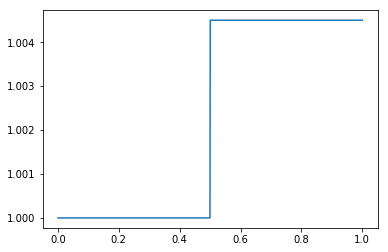

In [617]:
f = lambda x: test_function(x)
true_val = test_function_true_value
channels = Channels([np.random.rand, lambda N: np.random.rand(N)/2, lambda N: .5+np.random.rand(N)/2],
                    [lambda x: 1, lambda x: 2*(x<=.5), lambda x: 2*(x>.5)])
mcmci = MonteCarloMultiImportance(channels).get_interface_ratios(r1=0, r3=0, Nj=100)

ms = 0
err_mean = 0
N = 100
for i in range(N):
    E, err = mcmci(f, 100)
    ms += (E - true_val)**2 / N
    err_mean += err/N
print("rms vs mean error")
print(np.sqrt(ms), err_mean)
channels.plot_pdf()

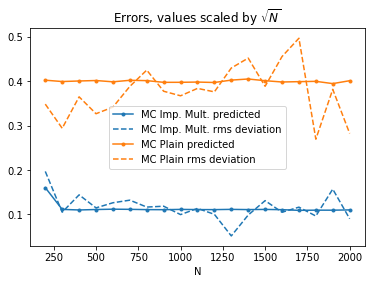

In [597]:
# use on test_function with the three probability distributions from before
p1 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*32 + bound(.4,x,.6)*2 + bound(.6,x,.8)*32 + bound(.8,x,1)*2)/70/.2
p2 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*22 + bound(.4,x,.6)*22 + bound(.6,x,.8)*22 + bound(.8,x,1)*2)/70/.2
p3 = lambda x: (bound(.2,x,.4)*((x-.2)/.2)**2 + bound(.6,x,.8)*((.8-x)/.2)**2 + bound(.4,x,.6))/(.2 + .1333333)
sampling1 = AcceptionRejection(p1, 3)
sampling2 = AcceptionRejection(p2, 2)
sampling3 = AcceptionRejection(p3, 3.5)
channels = Channels([sampling1, sampling2, sampling3], [p1, p2, p3])

mcmci = MonteCarloMultiImportance(channels).get_interface_ratios(Nj=100, r1=0, r2=.5, r3=.5)
compare_errors(test_function, test_function_true_value, Nmin=200, Nmax=2000, Nstep=100, iterations=10, 
               methods=[mcmci, MonteCarloPlain()])
plt.show()

-0.0036924321970757124 0.0026405995728318024


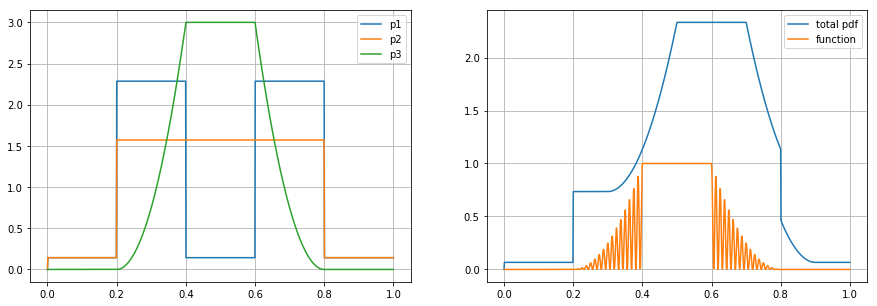

In [351]:
shift = .1
p3 = lambda x: (bound(.2,x,.4)*((x-.2)/.2)**2 + bound(.6,x,.8)*((.8-x)/.2)**2 + bound(.4,x,.6))/(.2 + .1333333)
sampling3_shifted = AcceptionRejection(lambda x: p3(x-shift), 3.5)
channels = Channels([sampling1, sampling2, sampling3_shifted], [p1, p2, lambda x: p3(x-shift)])
mcmci = MonteCarloMultiImportance(channels).get_interface_ratios(Nj=100, r1=.2, r2=.4, r3=.4)

plt.figure(figsize=(15,5))
plt.subplot(121)
x = np.linspace(0,1,1000)
plt.plot(x, p1(x), label="p1")
plt.plot(x, p2(x), label="p2")
plt.plot(x, p3(x), label="p3")
plt.grid()
plt.legend()

plt.subplot(122)
est, err = mcmci(test_function, 10000)
print(est-test_function_true_value, err)
channels.plot_pdf()
plt.plot(x,test_function(x), label="function")
plt.legend()
plt.grid()

plt.show()

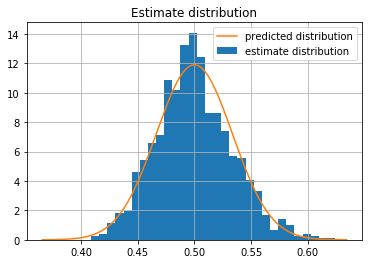

In [610]:
def compare_distribution(fn, true_val, N, iterations, method, bins=20):
    values = np.empty(iterations)
    mean_var = 0
    for i in range(iterations):
        values[i], var = method(fn, N)
        mean_var += var**2 / iterations
    plt.hist(values, bins=bins, normed=True, label="estimate distribution")
    x = np.linspace(true_val-4*np.sqrt(mean_var), true_val+4*np.sqrt(mean_var), 1000)
    plt.plot(x, np.exp(-(x-true_val)**2/2/mean_var) / np.sqrt(np.pi*2*mean_var), label="predicted distribution")
    plt.title("Estimate distribution")
    plt.grid()
    plt.legend(loc="best")
    
fn = lambda x: np.sin(2*np.pi*x)**2
channels = Channels([sampling1], [p1])
mcmci = MonteCarloMultiImportance(channels, var_weighted=False).get_interface_ratios(Nj=100, r1=0, r2=0, r3=1)
mcmci1 = MonteCarloImportance(1, sampling_fn=sampling1, pdf=p1)
# compare_distribution(fn, 0.5, 400, 1000, mcmci1, bins=30)
compare_distribution(fn, .5, 500, 1000, mcmci, bins=30)

# Sampling

### Importance Sampling
When, like in Importance Sampling Monte Carlo, there is a normalized pdf $g(x)$ approximating $f(x)$, the acception-rejection method can be used to generate values according to the $f$ distribution (where $f$ would be the non-normalized pdf). The AcceptionRejection class implements this.


## MCMCMC

In [875]:
class MC3(object):
    def __init__(self, dim, channels, fn, delta=None, initial_value=np.random.rand()):
        self.channels = channels
        self.mc_importance = MonteCarloMultiImportance(channels)
        self.fn = fn
        self.dim = dim
        
        self.sample_IS = MetropolisHasting(initial_value, self.fn, dim,
                                           lambda s, c: self.channels.pdf(c),
                                           lambda s: self.channels.sample(1)[0])
        self.sample_METROPOLIS = Metropolis(initial_value, self.fn, dim,
                                            self.generate_local)
        
        if np.ndim(delta) == 0:
            delta = np.ones(dim) * delta
        elif delta is None:
            delta = np.ones(dim) * .05
        elif len(delta) == dim:
            delta = np.array(delta)
        else:
            raise ValueError("delta must be None, a float, or an array of length dim.")
        self.delta = delta
        
        self.accept_min = 0.25
        self.accept_max = 0.5
        self.accept_mean = (0.25 + 0.5)/2
        
    def generate_local(self, state):
        zero = np.zeros(self.dim)
        one = np.ones(self.dim)
        return np.minimum(np.maximum(zero, state-self.delta/2), one-self.delta) + np.random.rand()*self.delta
        
    def __call__(self, Ns_integration, N_sample, beta, batch_size=None):
        if batch_size is None:
            batch_size = int((1 - beta) * N_sample / 10)
            
        self.integral, self.integral_var = self.mc_importance(fn, *Ns_integration)
        
        sample = np.empty((N_sample, self.dim))
        for i in range(N_sample):
            if np.random.rand() <= beta:
                self.sample_METROPOLIS.state = sample[i] = self.sample_IS(1)
            else:
                self.sample_IS.state = sample[i] = self.sample_METROPOLIS(1)
            
        return sample

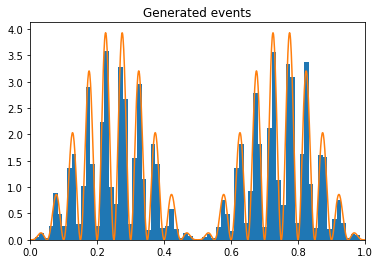

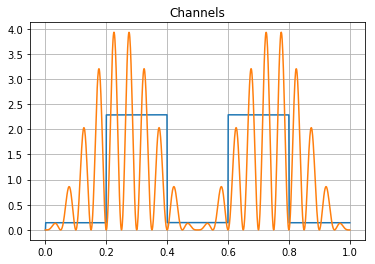

In [901]:
fn = lambda x: np.sin(2*np.pi*x)**2 * np.sin(10*2*np.pi*x)**2
mc3 = MC3(1, Channels([sampling1, sampling2, sampling3], [p1, p2, p3]), fn, delta=.1, initial_value=.5)
res = mc3(([], [500]*40, []), 30000, beta=.8)

plt.title("Generated events")
plt.hist(res, normed=True, bins=70)
plt.xlim(0, 1)
x = np.linspace(0, 1, 1000)
plt.plot(x, fn(x)/mc3.integral)
plt.show()

plt.title("Channels")
mc3.channels.plot_pdf()
plt.plot(x, fn(x)/mc3.integral)
plt.grid()
plt.show()